# Living Polymerization – CSTR Operation

## Theory

Many important polymers are produced continuously, often utilizing ingenious reactor designs that leverage the intrinsic characteristics of continuous stirred-tank reactors (CSTRs) and/or tubular reactors. When the polymer chain growth time is non-negligible relative to the reaction time scale, the residence time distribution (RTD) of the reaction zone significantly impacts the polymer structure.
A classic example illustrating these concepts is living polymerization in a CSTR or a cascade of CSTRs. For an ideal CSTR with a constant average residence time, $\tau$, the transient balances are as follows:

\begin{align*}
\frac{\textrm{d}[I]}{\textrm{d}t}   & = \frac{1}{\tau}\left([I]_{in} - [I]\right) - k_i [I] [M] \\
\frac{\textrm{d}[P_1]}{\textrm{d}t} & = \frac{1}{\tau}\left([P_1]_{in} - [P_1]\right) + (k_i [I] - k_p [P_1]) [M] \\
\frac{\textrm{d}[P_n]}{\textrm{d}t} & = \frac{1}{\tau}\left([P_n]_{in} - [P_n]\right) + k_p ([P_{n-1}] - [P_{n}]) [M], \;n \ge 2 \\
\frac{\textrm{d}[M]}{\textrm{d}t}   & = \frac{1}{\tau}\left([M]_{in} - [M]\right) - (k_i [I] + k_p \sum_{j=1}^\infty [P_j] )[M]
\end{align*}

These resemble the balances presented in Notebook 3 for a batch reactor, except for the inclusion of the inflow/outflow term. By defining an appropriate upper limit for the chain length $N$, we obtain a closed set of $N+2$ ordinary differential equations (ODEs) per reactor. In the case of a reactor cascade, the same equations apply to each vessel, with the output from reactor $i$ serving as the input to reactor $i+1$.

## Numerical Solution

Let us implement a method to simulate the behavior of living polymerization in a cascade of CSTRs with an arbitrary number of vessels of equal size.

In [1]:
%matplotlib widget
import ipywidgets as widgets
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numba import njit
import functools

First, we write a function to compute the time derivatives of the species concentrations for a single CSTR.

In [2]:
@njit(fastmath=True)
def living_polymerization_cstr(t: float,
                               C: np.ndarray,
                               Cin: np.ndarray,
                               ki: float,
                               kp: float,
                               tau: float
                               ) -> np.ndarray:
    r"""Molar balances for living polymerization in a single CSTR.

    Both `C` and `Cin` have the following layout:
    C = [I, M, P_1..P_N]

    Parameters
    ----------
    t : float
        Time.
    C : np.ndarray
        Concentration vector.
    Cin : np.ndarray
        Inlet concentration vector.
    ki : float
        Initiation rate coeficient.
    kp : float
        Propagation rate coeficient.
    tau : float
        Average residence time per vessel.

    Returns
    -------
    np.ndarray
        Time derivative of the concentration vector.
    """
    # Unpack the concentration vector
    I = C[0]
    M = C[1]
    P = C[2:]

    # Allocate derivative vector
    Cdot = np.empty_like(C)
    # Pdot is a view of Cdot; updating Pdot updates Cdot
    Pdot = Cdot[2:]

    # Compute reaction rates
    Cdot[0] = -ki*I*M
    Cdot[1] = -(ki*I + kp*P.sum())*M
    Pdot[0] = ki*I*M - kp*M*P[0]
    Pdot[1:] = kp*M*(P[0:-1] - P[1:])
    
    # Add in/outflow
    Cdot += (Cin - C)/tau

    return Cdot

The state vector of the reactor cascade is simply the concatenation of the concentration vectors from each reactor. Thus, $\dot{y}$ can be evaluated by calling the function `living_polymerization_cstr` for each reaction unit, keeping in mind that the output from one reactor is fed into the next.

In [3]:
@njit(fastmath=True)
def model_ydot(t: float,
               y: np.ndarray,
               Cin1: np.ndarray,
               ki: float,
               kp: float,
               tau: float,
               ncstr: int
               ) -> np.ndarray:
    """Derivative of the state vector, dy/dt.

    The state vector of the reactor cascade is the concatenation of the 
    concentration vectors of each individual CSTR.

    y = [C(cstr-1), C(cstr-2), ..., C(cstr-n)]

      inlet (Cin)
         |
         v
    +----------+      +----------+               +----------+
    | 1st CSTR | ---> | 2nd CSTR | ---> ... ---> | n-th CSTR|
    +----------+      +----------+               +----------+
                                                      |
                                                      v
                                                    outlet

    Parameters
    ----------
    t : float
        Time.
    y : np.ndarray
        State vector.
    Cin1 : np.ndarray
        Inlet concentration vector of 1st CSTR.
    ki : float
        Initiation rate coeficient.
    kp : float
        Propagation rate coeficient.
    tau : float
        Average residence time per vessel.
    ncstr : int
        Number of CSTRs.

    Returns
    -------
    np.ndarray
        Time derivative of the state vector.
    """
    # Reshape the state vector to a matrix C[cstr, species]
    C = y.reshape((ncstr, -1))

    # Allocate derivative vector
    ydot = np.empty_like(y)
    Cdot = ydot.reshape((ncstr, -1))

    # Solve each CSTR (could be parallelized)
    for i in range(ncstr):
        if i == 0:
            Cin = Cin1
        else:
            Cin = C[i-1, :]
        Cdot[i, :] = living_polymerization_cstr(t, C[i, :], Cin, ki, kp, tau)

    return ydot

Lastly, we perform the numerical integration using a suitable ODE solver. This system is non-stiff, therefore we can use an explicit scheme.

In [4]:
@functools.cache
def solve_model(Iin: float,
                Min: float,
                ki: float,
                kp: float,
                tau: float,
                ncstr: int,
                tend: float
                ) -> tuple[np.ndarray, np.ndarray]:
    """Solve the dynamic model.

    Parameters
    ----------
    Iin : float
        Inlet initiator concentration of the 1st CSTR.
    Min : float
        Inlet monomer concentration of the 1st CSTR.
    ki : float
        Initiation rate coeficient.
    kp : float
        Propagation rate coeficient.
    tau : float
        Average residence time per vessel.
    ncstr : int
        Number of CSTRs.
    tend : float
        End simulation time.

    Returns
    -------
    tuple[np.ndarray, np.ndarray]
        Times, and reshaped solution as array C[cstr, species, time]. 
    """

    # Upper bound of the chain length (guess)
    N = np.max([10, 8*int(Min/Iin)]) + 1

    # Initial condition (all species = 0)
    y0 = np.zeros(ncstr*(N+2))

    # Inlet concentration vector
    Cin = np.zeros(N+2)
    Cin[0] = Iin
    Cin[1] = Min

    # Solve ODE set
    solution = solve_ivp(model_ydot,
                         t_span=(0, tend),
                         y0=y0,
                         args=(Cin, ki, kp, tau, ncstr),
                         method='RK45',  # non-stiff ODEs
                         rtol=1e-4,
                         atol=1e-9
                         )

    # Unpack and reshape the solution
    t = solution.t
    C = solution.y.reshape((ncstr, -1, t.size))

    return t, C

### ODE Solution

Let's make some educated guesses and run the model.

In [5]:
Iin = 1e-2
Min = 1e0
ki = 1e-3
kp = 100*ki
ncstr = 5
tau = 1e3
tend = 3*ncstr*tau

t, C = solve_model(Iin, Min, ki, kp, tau, ncstr, tend)

### Plots

#### Time-Dependent Variables

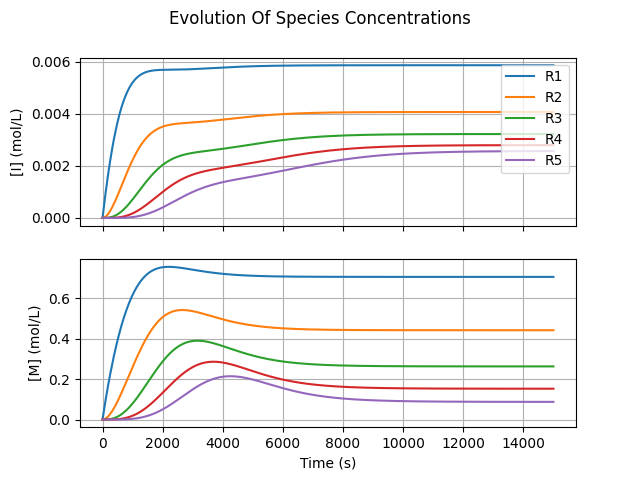

In [6]:
fig1, ax = plt.subplots(2, 1, sharex=True)
fig1.suptitle("Evolution of species concentrations".title())
fig1.canvas.header_visible = False

for i in range(ncstr):
    ax[0].plot(t, C[i, 0, :], label=f"R{i+1}")  # [I]
    ax[1].plot(t, C[i, 1, :])                   # [M]

ax[0].grid(True)
ax[1].grid(True)
ax[0].set_ylabel("[I] (mol/L)")
ax[1].set_ylabel("[M] (mol/L)")
ax[-1].set_xlabel("Time (s)")
ax[0].legend(loc='upper right')

#### Chain Length Distribution

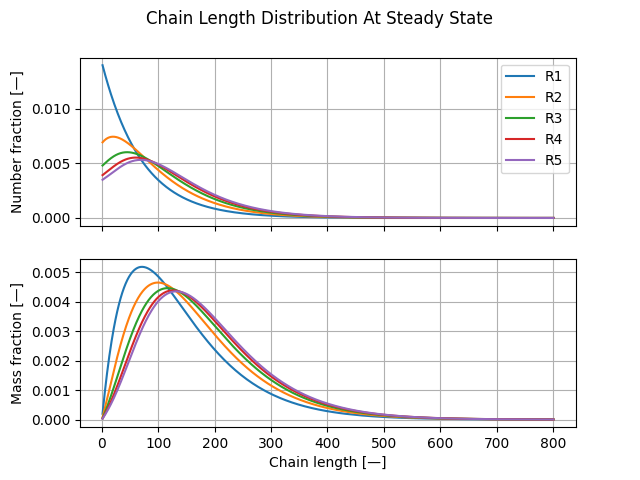

In [7]:
fig2, ax = plt.subplots(2, 1, sharex=True)
fig2.suptitle("Chain length distribution at steady state".title())
fig2.canvas.header_visible = False

# Chain length vector
N = C.shape[1] - 2
s = np.arange(1, N+1)

# Number distribution
CLDn = C[:, 2:, :].copy()
CLDn /= (CLDn.sum(axis=1, keepdims=True) + 1e-15)

# Mass distribution
CLDm = CLDn*s[:, np.newaxis]
CLDm /= (CLDm.sum(axis=1, keepdims=True) + 1e-15)

for i in range(ncstr):
    ax[0].plot(s, CLDn[i, :, -1], label=f"R{i+1}")
    ax[1].plot(s, CLDm[i, :, -1])

ax[0].set_ylabel("Number fraction [—]")
ax[1].set_ylabel("Mass fraction [—]")
ax[-1].set_xlabel("Chain length [—]")
ax[0].grid(True)
ax[1].grid(True)
ax[0].legend(loc='upper right')
# ax[-1].set_xscale('log')

#### CLD vs Backmixing 

interactive(children=(FloatLogSlider(value=0.01, continuous_update=False, description='[I] inlet (mol/L)', max…

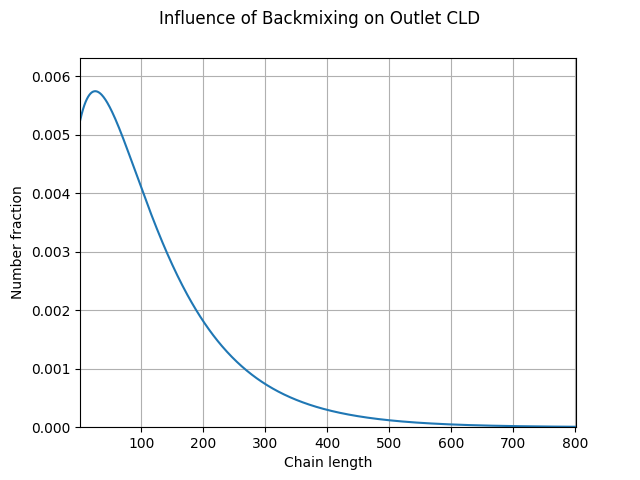

In [8]:
fig3, ax = plt.subplots()
fig3.suptitle("Influence of Backmixing on Outlet CLD")
fig3.canvas.header_visible = False

# Add empty CLD line (to be updated)
line, = ax.plot([], [], label="number")

ax.set_ylabel("Number fraction")
ax.set_xlabel("Chain length")
ax.grid(True)


def update_plot(Iin: float, Min: float, ki: float, kp: float,
                tau_total: float, ncstr: int) -> None:

    # Residence time per vessel
    tau = tau_total/ncstr

    # Total simulation time
    tend = 5*tau_total

    # Solve model
    _, C = solve_model(Iin, Min, ki, kp, tau, ncstr, tend)

    # Chain length vector
    N = C.shape[1] - 2
    s = np.arange(1, N+1)

    # Final number distribution
    Wn = C[ncstr-1, 2:, -1].copy()
    Wn /= (Wn.sum() + 1e-15)

    # Update the plot
    line.set_data(s, Wn)
    ax.set_xlim(s[0], s[-1])
    ax.set_ylim(0., 1.1*np.max(Wn))
    fig3.canvas.draw()

    return


_ = widgets.interact(update_plot,
                     Iin=widgets.FloatLogSlider(
                         description=r"[I] inlet (mol/L)",
                         value=1e-2,
                         min=-3,
                         max=-1,
                         step=0.1,
                         continuous_update=False),
                     Min=widgets.FloatLogSlider(
                         description=r"[M] inlet (mol/L)",
                         value=1e0,
                         min=-1,
                         max=1,
                         step=0.1,
                         continuous_update=False),
                     ki=widgets.FloatLogSlider(
                         description=r"ki (L/mol/s)",
                         value=1e-3,
                         min=-4,
                         max=-2,
                         step=0.1,
                         continuous_update=False),
                     kp=widgets.FloatLogSlider(
                         description=r"kp (L/mol/s)",
                         value=1e-1,
                         min=-2,
                         max=0,
                         step=0.1,
                         continuous_update=False),
                     tau_total=widgets.FloatSlider(
                         description=r"total residence time (s)",
                         value=5e3,
                         min=1e2,
                         max=1e4,
                         step=1e2,
                         continuous_update=False),
                     ncstr=widgets.IntSlider(
                         description=r"number of CSTRs (-)",
                         value=2,
                         min=1,
                         max=10,
                         step=1,
                         continuous_update=False)
                     )

## Questions/Extras

1. Explain the shape of the $[I]$ and $[M]$ temporal profiles.
1. What appends to the final CLD as we increase the number of CSTRs at constant residence time? Why?
1. Could you have (approximately) predicted the shape of the chain length distribution without having solved these equations?